In [1]:
import struct
from struct import unpack

import json
import numpy as np
import pandas as pd
import os
import time
import re

import PIL
from PIL import ImageDraw

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set(style='white', context='notebook', palette='deep')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        #'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        #'timestamp': timestamp,
        'image': image
    }

def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break
                
def drawing2array(drawing):
    # Original images are 255x255, add extra 2.5 to each edge.
    im = PIL.Image.new(mode='L', size=(260, 260))
    draw = PIL.ImageDraw.Draw(im)

    # Shift the strokes from edges by 2.5 pixels, convert them to valid format.
    for stroke in drawing:
        stroke_shifted = list(map(lambda x: tuple([i+2.5 for i in x]), 
                                  tuple(zip(stroke[0], stroke[1])))
                             )
        draw.line(stroke_shifted, fill=255, width=3)

    im = im.resize((56, 56), resample=3)
    im = np.array(im)
    # Clip max values to make lines less blury.
    return im.clip(0, int(im.max()/2))

In [5]:
max_imgs_per_category = 1e5

df = []
imgs = []
files_to_read = [f for f in os.listdir('data/') if f.endswith('.bin')]
t_start = time.time()

for i, f in enumerate(files_to_read):
    
    imgs_meta = []
    category = f.split('-')[-1].split('.')[0]  # Cut from the filename.
    if category not in ['airplane', 'bat', 'bird', 'car', 'bus', 'mug', 'cup']:
        continue
    for j, drawing in enumerate(unpack_drawings('data/'+f)):
        img = drawing.pop('image')
        #img = drawing2array(img)
        imgs.append(img)
        imgs_meta.append(drawing)
        
        if j % 1000 == 0:
            time_elapsed = round((time.time() - t_start)/60, 1)
            print('Processing file {} out of {}. Done {}k images in current file. Minutes elapsed {}      '
                  .format(i+1, len(files_to_read), int(j/1000), time_elapsed), end='\r')
            
        if j+1 >= max_imgs_per_category:
            break

    df_tmp = pd.DataFrame()
    df_tmp['countrycode'] = [re.sub('[^A-Z]+', '', str(drawing['countrycode']))
                             for d in imgs_meta]
    df_tmp['recognized'] = [d['recognized'] for d in imgs_meta]
    df_tmp['target'] = category
    df.append(df_tmp)
    
df = pd.concat(df, axis=0).reset_index(drop=True)
imgs = np.array(imgs)

del imgs_meta, df_tmp

In [6]:
#resolution = imgs.shape[1]
#mb_per_img = (resolution ** 2 * 8) / 8 / 1024 / 1024 
#print('Bitmaps\' size: {} MB'.format(round(imgs.shape[0] * mb_per_img, 2)))
print(df.shape[0])
np.save('data/strokes_raw.npy', imgs)
df.to_csv('data/df.csv', index=False)

700000


In [70]:
imgs.shape[0], df.shape[0]

(140000, 140000)

In [54]:
np.save('data/strokes_raw.npy', imgs)
imgs = np.load('data/strokes_raw.npy')

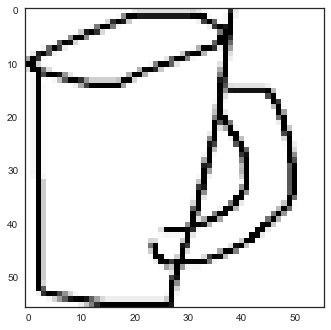

In [55]:
plt.imshow(drawing2array(imgs[0]))

In [ ]:
plt.subplots(figsize=(15,6))

nrows, ncols = 3, 7
for i in range(nrows * ncols):
    image_ind = np.random.choice(range(len(imgs)))
    plt.subplot(nrows, ncols, i+1)
    plt.axis('off')
    plt.imshow(imgs[image_ind])
    plt.title(df.target.loc[image_ind], fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
def find_most_common(imgs, df, label):
    mask = df.target==label
    mean_img = imgs[mask].mean(axis=0)
    
    plt.figure(figsize=(4,4))
    plt.imshow(mean_img)
    
    # Removes half-empty pictures.
    mask = (mask) & (imgs.mean(axis=(1,2)) >= mean_img.mean())
    diffs = np.sum(((mean_img - imgs[mask])**2), axis=(1,2))
    best_match_index = np.argmin(diffs)
    
    plt.figure(figsize=(4,4))
    plt.imshow(imgs[mask][best_match_index])
    
    return mean_img

mi = find_most_common(imgs, df, 'bat')

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=0.001, max_iter=500)#, multi_class='multinomial', solver='lbfgs', max_iter=500)
lr.fit(train.reshape(-1, 28*28), ytrain)

plt.imshow(lr.coef_[0].reshape(28,28))

In [ ]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

le = LabelEncoder()
y = le.fit_transform(targets)
y = to_categorical(y).astype(int)
imgs = imgs.reshape(-1, 28, 28, 1)

train, valid, ytrain, yvalid = train_test_split(imgs, y, test_size = 0.25, random_state=0)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=1e-4),
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_val,Y_val),
#                               verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])
#model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train, ytrain,
          batch_size=1024,
          epochs=50, verbose=1,
          validation_data=(
              valid, yvalid)
            )

In [ ]:
#model.save('nnet_v1.h5')
model.load_weights('nnet_v1.h5')

In [ ]:
import keras
model =  keras.models.load_model('nnet_v1.h5')

In [ ]:
np.save('classes.npy', le.classes_)
lec = np.load('classes.npy')

In [ ]:
lec

In [ ]:
from sklearn.metrics import confusion_matrix
y_hat = model.predict(valid)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(yvalid, axis=1)
confusion = np.array(confusion_matrix(y_true, y_pred))
print(confusion)

In [ ]:
sns.heatmap(confusion.astype('float') / confusion.sum(axis=1),
            fmt='.0%',
            annot=True, 
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_),
           )
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
mask = y_hat[range(y_hat.shape[0]), np.argmax(yvalid, axis=1)]>0.95

In [ ]:
i = 929
print(le.classes_[np.argmax(yvalid[mask][i])])
plt.imshow(valid[mask][i].reshape(28,28))

In [ ]:
plt.hist(y_hat[range(y_hat.shape[0]), np.argmax(yvalid, axis=1)], bins=np.arange(0,1,0.01));

In [ ]:
from PIL import Image
import PIL
import glob
import cv2

In [ ]:
img2 = img2 / 0

In [ ]:
img = Image.open('f1.jpg')

plt.imshow(img)
plt.show()

for resample in [PIL.Image.BOX, PIL.Image.BILINEAR, PIL.Image.HAMMING, PIL.Image.LANCZOS, 1,3, 5]:
    img2 = img.resize((28,28), resample=resample)
    img2 = np.array(img2)[:, :, 0].astype(float)
    img2 = - img2 + img2.max()
    img2 /= img2.max()/2
    img2 = img2.clip(0, 1)
    plt.imshow(img2)
    plt.show()
# plt.imshow(img)

In [ ]:
img = Image.open('f1.jpg')

for resample in [PIL.Image.HAMMING, PIL.Image.BOX, PIL.Image.LANCZOS,  1, 3, 5]:
    img2 = img.resize((28,28), resample=resample)
    img2 = np.array(img2)[:, :, 0].astype(float)
    img2 = - img2 + img2.max()
    img2 /= img2.max()/2
    img2 = img2.clip(0, 1)
    
    preds = model.predict(img2.reshape(1, 28, 28, 1))
    print(le.classes_[preds.argmax()], preds.max())
    print(preds)
    print()

In [ ]:
preds.sum()

In [ ]:
le.classes_

In [ ]:
all_categories = ['airplane', 'bat', 'bird', 'bus', 'car', 'cup', 'mug']
print('\n'.join(np.random.choice(all_categories, 5, False)))